In [250]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torch import distributions
from torch import optim
import matplotlib.pyplot as plt
import pathlib
import time
from collections import defaultdict
%matplotlib inline

In [251]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=50, nf=32, device=torch.device('cpu')):
        super(Encoder, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=nf, out_channels=2*nf, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=2*nf, out_channels=4*nf, kernel_size=3)
        self.linear1 = nn.Linear(in_features=4*nf, out_features=100)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mu_linear = nn.Linear(in_features=100, out_features=latent_dim)
        self.logvar_linear = nn.Linear(in_features=100, out_features=latent_dim)
        self.N = torch.distributions.Normal(0,1)
        self.N.loc = self.N.loc.to(self.device)
        self.N.scale = self.N.scale.to(self.device)
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.linear1(x))
        mu = self.mu_linear(x)
        log_var = self.logvar_linear(x)
        return mu, log_var
        
class Decoder(nn.Module):
    def __init__(self, latent_dim=50, nf=32):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(in_features=latent_dim, out_features=100)
        self.linear2 = nn.Linear(in_features=100, out_features=128)
        self.tconv1 = nn.ConvTranspose2d(in_channels=4*nf, out_channels=2*nf, kernel_size=7)
        self.tconv2 = nn.ConvTranspose2d(in_channels=2*nf, out_channels=nf, kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(in_channels=nf, out_channels=1, kernel_size=2, stride=2)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = z.view(z.shape[0],-1,1,1)
        z = F.relu(self.tconv1(z))
        z = F.relu(self.tconv2(z))
        xhat = self.tconv3(z)
        return xhat

class VAE(nn.Module):
    def __init__(self, latent_dim=50, nf=32, device=torch.device('cpu')):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, nf, device=device)
        self.decoder = Decoder(latent_dim, nf)
        self.to(device)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        sigma = torch.exp(log_var/2)
        # Reparameterization
        epsilon = self.encoder.N.sample(mu.shape)
        z = mu + sigma*epsilon
        xhat = self.decoder(z)
        return xhat, x, mu, log_var

In [258]:
def elbo_loss(xhat, x, mu, logvar):
    batch_size = xhat.shape[0]
    recon_loss = F.mse_loss(xhat, x, reduction='sum') / batch_size
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),axis=1)
    kl_loss = kl_div.mean()
    beta = 2 #kl_loss/recon_loss
    total_loss = recon_loss + beta  * kl_loss
    return total_loss, recon_loss, kl_loss, beta

def print_model_summary(model):
    #print(summary(model.encoder, input_size=(1,28,28)))
    #print(summary(model.decoder, input_size=(1, model.nf * 16)))
    print(summary(model))

def save_plot(losses, beta, name=None):
    pathlib.Path("results").mkdir(parents=True, exist_ok=True)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if not name:
        save_plot_path = "results/plot-"+timestr
    else:
        save_plot_path = "results/"+name
    epochs = len(losses['kl_loss'])
    plt.plot(range(1,epochs+1), losses['total_loss'], label='Total loss')
    plt.plot(range(1,epochs+1), losses['recon_loss'], label='Reconstruction loss')
    plt.plot(range(1,epochs+1), losses['kl_loss'], label='KL loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"beta = {beta}")
    plt.savefig(save_plot_path, facecolor='w', edgecolor='none')
    plt.show()

def save_model(model, name=None):
    pathlib.Path("results/saved_models").mkdir(parents=True, exist_ok=True)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if not name:
        save_model_path = "results/saved_models/VAE_MNIST-"+timestr+".pth"
    else:
        save_model_path = "results/saved_models/"+name+".pth"
    torch.save(model.state_dict(), save_model_path)

# load model
def load_model(model_name, model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    model_path = "results/saved_models/"+model_name+".pth"
    try:
        model.load_state_dict(torch.load(model_path, weights_only=True))
    except OSError as e:
        print(f"{e.strerror}: {e.filename}")
        return None
    return model

def train_model(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    total_kl_loss = 0
    total_recon_loss = 0
    for batchidx, (data, _) in enumerate(train_loader):
        #print(f"batch id: {batchidx}, data shape: {data.shape}")
        data = data.to(device)
        optimizer.zero_grad()
        xhat, x, mu, logvar = model(data)
        loss, recon_loss, kl_loss, beta = elbo_loss(xhat, x, mu, logvar)
        #print(f"loss: {loss.item()}")
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        loss.backward()
        optimizer.step()
    avg_kl_loss = total_kl_loss/(batchidx+1)
    avg_recon_loss = total_recon_loss/(batchidx+1)
    avg_loss = train_loss/(batchidx+1)
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\t")
    return avg_loss, avg_recon_loss, avg_kl_loss, beta

In [254]:
# Set training parameters
batch_size = 128
learning_rate = 1e-1
latent_dim = 50
nf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='../data/MNIST', download=True, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
model = VAE(latent_dim, nf).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"device: {device}")
print(f"train size: {len(train_data)}")
print(f"train loader size: {len(train_loader)}")
print_model_summary(model)

device: cuda
train size: 60000
train loader size: 468
Layer (type:depth-idx)                   Param #
VAE                                      --
├─Encoder: 1-1                           --
│    └─Conv2d: 2-1                       320
│    └─Conv2d: 2-2                       18,496
│    └─Conv2d: 2-3                       73,856
│    └─Linear: 2-4                       12,900
│    └─MaxPool2d: 2-5                    --
│    └─Linear: 2-6                       5,050
│    └─Linear: 2-7                       5,050
├─Decoder: 1-2                           --
│    └─Linear: 2-8                       5,100
│    └─Linear: 2-9                       12,928
│    └─ConvTranspose2d: 2-10             401,472
│    └─ConvTranspose2d: 2-11             8,224
│    └─ConvTranspose2d: 2-12             129
Total params: 543,525
Trainable params: 543,525
Non-trainable params: 0


Train epoch: 1 [59904/60000          (100%)]	Loss: 55.233373	
Train epoch: 2 [59904/60000          (100%)]	Loss: 51.901171	
Train epoch: 3 [59904/60000          (100%)]	Loss: 50.494014	
Train epoch: 4 [59904/60000          (100%)]	Loss: 48.954675	
Train epoch: 5 [59904/60000          (100%)]	Loss: 48.127797	
Train epoch: 6 [59904/60000          (100%)]	Loss: 47.439486	
Train epoch: 7 [59904/60000          (100%)]	Loss: 46.211249	
Train epoch: 8 [59904/60000          (100%)]	Loss: 44.918307	
Train epoch: 9 [59904/60000          (100%)]	Loss: 44.170806	
Train epoch: 10 [59904/60000          (100%)]	Loss: 43.565170	
Train epoch: 11 [59904/60000          (100%)]	Loss: 42.926567	
Train epoch: 12 [59904/60000          (100%)]	Loss: 42.212281	
Train epoch: 13 [59904/60000          (100%)]	Loss: 41.624893	
Train epoch: 14 [59904/60000          (100%)]	Loss: 41.216585	
Train epoch: 15 [59904/60000          (100%)]	Loss: 40.803561	
Train epoch: 16 [59904/60000          (100%)]	Loss: 40.358606	
T

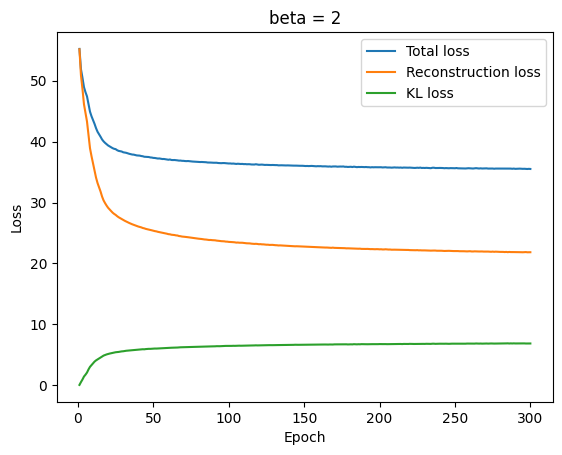

In [376]:
# Run training loops
epochs = 300
losses = defaultdict(list)
for epoch in range(1,epochs+1):
    avg_loss, avg_recon_loss, avg_kl_loss, beta = train_model(model, device, train_loader, optimizer, epoch)
    losses['total_loss'].append(avg_loss)
    losses['recon_loss'].append(avg_recon_loss)
    losses['kl_loss'].append(avg_kl_loss)
save_plot(losses, beta)
save_model(model, name=f"vaemnist_beta_{beta}")

In [260]:
# load saved model
latent_dim = 50
nf = 32
model_name = 'vaemnist_beta_2'
loaded_model = load_model(model_name,VAE,latent_dim=50, nf=32, device=device)
if loaded_model:
    print_model_summary(loaded_model)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Encoder: 1-1                           --
│    └─Conv2d: 2-1                       320
│    └─Conv2d: 2-2                       18,496
│    └─Conv2d: 2-3                       73,856
│    └─Linear: 2-4                       12,900
│    └─MaxPool2d: 2-5                    --
│    └─Linear: 2-6                       5,050
│    └─Linear: 2-7                       5,050
├─Decoder: 1-2                           --
│    └─Linear: 2-8                       5,100
│    └─Linear: 2-9                       12,928
│    └─ConvTranspose2d: 2-10             401,472
│    └─ConvTranspose2d: 2-11             8,224
│    └─ConvTranspose2d: 2-12             129
Total params: 543,525
Trainable params: 543,525
Non-trainable params: 0


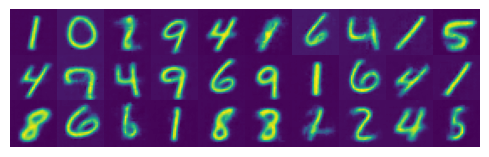

In [288]:
# generate images
rows, cols = 3, 10
z = loaded_model.encoder.N.sample([rows*cols,latent_dim])
xhat = loaded_model.decoder(z)
xhat = xhat.view(rows, cols, *xhat.shape[1:]).detach().cpu()

fig, axs = plt.subplots(rows, cols, figsize=(5,5))
for A, I in zip(axs,xhat):
    for ax, img in zip(A,I):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.imshow(img[0])
fig.tight_layout()
fig.subplots_adjust(hspace=-0.88, wspace=0)
plt.show()
#plt.imshow(xhat.detach().cpu()[0,0], cmap='Greys')

## Scratch cells (Use below cells to scribble)

cuda
torch.float32


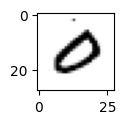

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='../data/MNIST', download=True, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
inputs, labels = next(iter(train_loader))
im = inputs[2]
im1 = torch.einsum('chw->hwc',[im])
print(im.dtype)
plt.figure(figsize=(1,1))
plt.imshow(im1, cmap='Greys')
#plt.show()

torch.Size([64, 1, 28, 28])
786.5143432617188


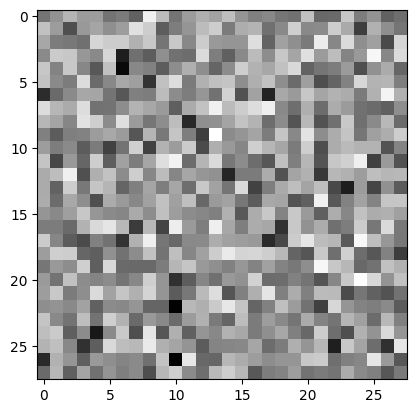

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(64,1,28,28).to(device)
latent_dim = 10
model = VAE(latent_dim).to(device)
xhat, x, mu, logvar = model(x)
print(xhat.shape)
plt.imshow(xhat.detach().cpu()[0,0], cmap='Greys')
loss,*_ = elbo_loss(xhat, x, mu, logvar)
print(loss.item())